In [ ]:
# =========================
# 0) Imports y configuración
# =========================
from statsbombpy import sb
import pandas as pd
import numpy as np
from collections import Counter
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from numpy.linalg import norm
from random import sample
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

# Asumo que ya tienes: creds = {...}
# Ejemplo (NO ejecutes si ya lo tienes):
creds = {"user": "itam_hackathon@hudl.com", "passwd": "pGwIprel"}

In [ ]:
# ==============================================
# Utilidades para explorar competiciones/seasons
# ==============================================
def available_seasons(competition_id, creds):
    """Devuelve DataFrame con seasons disponibles para una competición."""
    comps = sb.competitions(creds=creds)
    df = comps[comps["competition_id"].eq(competition_id)][
        ["competition_id", "competition_name", "season_id", "season_name"]
    ].drop_duplicates().sort_values("season_id")
    if df.empty:
        print(f"[INFO] No hay seasons para competition_id={competition_id}.")
    return df

def list_matches(competition_id, season_id, creds):
    """Devuelve DataFrame de partidos para una temporada."""
    matches = sb.matches(competition_id=competition_id, season_id=season_id, creds=creds)
    if matches is None or matches.empty:
        print(f"[INFO] Season {season_id} sin partidos o sin permisos.")
        return pd.DataFrame()
    # columnas útiles
    cols = ["match_id", "match_date", "home_team", "away_team", "competition_stage"]
    cols = [c for c in cols if c in matches.columns]
    return matches[cols].sort_values("match_date")


In [ ]:
# ==============================================
# Lectura segura de eventos (salta vacíos)
# ==============================================
def safe_events(match_id, creds, include_360_metrics=False):
    """
    Devuelve DataFrame de eventos (uno por evento).
    Si el partido no tiene eventos, o la cuenta no tiene acceso, retorna DF vacío.
    """
    try:
        ev = sb.events(match_id=match_id, creds=creds, include_360_metrics=include_360_metrics)
        if ev is None or (isinstance(ev, pd.DataFrame) and ev.empty):
            print(f"[WARN] match_id={match_id}: sin eventos, lo salto.")
            return pd.DataFrame()
        return ev
    except Exception as e:
        print(f"[WARN] match_id={match_id}: error al pedir eventos ({e}). Lo salto.")
        return pd.DataFrame()


In [ ]:
# ===================================================
# Descarga por temporadas
# ===================================================
def fetch_events_for_seasons(competition_id, season_ids, creds, team_filter=None, include_360_metrics=False):
    """
    Recorre seasons -> matches -> events y concatena todo en un solo DataFrame.
    team_filter: str con el nombre EXACTO del equipo (como aparece en matches['home_team'] / ['away_team'])
    """
    chunks = []
    for sid in season_ids:
        matches = sb.matches(competition_id=competition_id, season_id=sid, creds=creds)
        if matches is None or matches.empty:
            print(f"[INFO] season_id={sid}: sin matches.")
            continue

        if team_filter:
            matches = matches[(matches["home_team"] == team_filter) | (matches["away_team"] == team_filter)]
            print(f"[INFO] season_id={sid}: {len(matches)} partidos del equipo '{team_filter}'.")
        else:
            print(f"[INFO] season_id={sid}: {len(matches)} partidos totales.")

        for mid in matches["match_id"].unique():
            ev = safe_events(mid, creds=creds, include_360_metrics=include_360_metrics)
            if ev.empty:
                continue
            ev["competition_id"] = competition_id
            ev["season_id"] = sid
            ev["match_id"] = mid
            chunks.append(ev)

    if not chunks:
        print("[ERROR] No se obtuvieron eventos. Revisa seasons/equipo/permisos.")
        return pd.DataFrame()

    return pd.concat(chunks, ignore_index=True)

In [ ]:
# ==============================================
# Primero inspecciona temporadas disponibles
# ==============================================
COMP = 73  # Liga MX
seasons_df = available_seasons(COMP, creds)
seasons_df

,competition_id,competition_name,season_id,season_name
3,73,Liga MX,108,2021/2022
2,73,Liga MX,235,2022/2023
1,73,Liga MX,281,2023/2024
0,73,Liga MX,317,2024/2025


In [38]:
# Elige seasons por ID a partir del DF anterior:
# Por ejemplo, toma 1–2 primero para probar que todo carga
#SEASONS = seasons_df["season_id"].tail(1).tolist()  # ajusta a las que quieras
#TEAM = None  # o p.ej. "Club América" exactamente como aparece en 'home_team'/'away_team'

# Trae eventos (pon include_360_metrics=True si tu cuenta tiene 360 y lo quieres)
#events = fetch_events_for_seasons(
#    competition_id=COMP,
#    season_ids=SEASONS,
#    creds=creds,
#    team_filter=TEAM,
#    include_360_metrics=False
#)

events.shape, events.columns[:136] # muestra las columnas del DataFrame de eventos


((1155952, 136),
 Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_offensive',
        'ball_recovery_recovery_failure', 'carry_end_location',
        'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
        'clearance_left_foot', 'clearance_right_foot',
        ...
        'block_save_block', 'shot_redirect', 'shot_shot_shot_assist',
        'shot_open_goal', 'player_off_permanent',
        'goalkeeper_shot_saved_to_post', 'shot_saved_to_post',
        'shot_shot_goal_assist', 'goalkeeper_lost_out',
        'goalkeeper_success_out'],
       dtype='object', length=136))

In [ ]:
# ==============================================
# Sanity checks y guardado a disco
# ==============================================
# Cantidad de partidos únicos
print("#partidos:", events[["season_id", "match_id"]].drop_duplicates().shape[0])
# Cantidad de eventos totales
print("#eventos:", len(events))

# Existencia de tipo de evento
print("Tiene 'type'?:", "type" in events.columns)
# Existencia de ubicación del evento
print("Tiene 'location'?:", "location" in events.columns)

# Existencia de pass_cluster_label
print("Tiene 'pass_cluster_label'?:", "pass" in events.columns and "pass_cluster_label" in events["pass"].iloc[0] if len(events) else False)

# Guarda una copia a parquet para trabajar después sin repetir llamadas
out_path = "events_ligamx.parquet"
#vents.to_parquet(out_path, index=False)
print(f"Guardado → {out_path}")


#partidos: 340
#eventos: 1155952
Tiene 'type'?: True
Tiene 'location'?: True
Tiene 'pass_cluster_label'?: False
Guardado → events_ligamx.parquet


In [8]:
events.to_pickle("events_ligamx.pkl") # guardado alternativo como pickle

In [ ]:
def _is_dictlike(x):
    # Función que determina si un valor es de tipo diccionario.
    return isinstance(x, dict)

def detect_schema(df: pd.DataFrame):
    # Función que recibe un DataFrame y construye un diccionario con el esquema detectado.
    info = {}

    # TYPE
    if 'type' in df.columns and df['type'].notna().any() and _is_dictlike(df['type'].dropna().iloc[0]):
        info['type_mode'] = 'nested'
        info['type_name_col'] = ('type','name')
        # Si existe la columna 'type', hay al menos un valor no nulo, y el primer no nulo es un diccionario asume formato anidado.
    elif 'type_name' in df.columns:
        info['type_mode'] = 'flat'
        info['type_name_col'] = 'type_name'
        # Si no es anidado pero existe 'type_name', asume formato plano.
    else:
        # Si no detecta ninguna de las variantes, marca 'type' como ausente.
        info['type_mode'] = 'missing'
        info['type_name_col'] = None

    # PLAYER
    if 'player' in df.columns and df['player'].notna().any() and _is_dictlike(df['player'].dropna().iloc[0]):
        # Si existe player, hay no nulos, y el primero es diccionario, asume formato anidado.
        info['player_mode'] = 'nested'
        info['player_id_col']   = ('player','id')
        info['player_name_col'] = ('player','name')
    else:
        # Si no es anidado, intenta detectar columnas planas.
        # comunes en SBPy
        pid = 'player_id' if 'player_id' in df.columns else None
        pname = 'player_name' if 'player_name' in df.columns else ('player' if 'player' in df.columns else None)
        info['player_mode'] = 'flat' if pid or pname else 'missing'
        info['player_id_col']   = pid
        info['player_name_col'] = pname

    # LOCATION
    loc_mode = 'missing'
    # Asume por defecto que faltan.
    if 'location' in df.columns and df['location'].notna().any():
        # Si existe location y hay no nulos, toma el primer no nulo (formato típico: [x,y])
        v = df['location'].dropna().iloc[0]
        if isinstance(v,(list,tuple)) and len(v)>=2: loc_mode = 'nested'
    if loc_mode == 'missing':
        # Si no detectó anidados, prueba alternativas planas.
        if {'location_x','location_y'}.issubset(df.columns):
            loc_mode = 'flat_xy'
        elif {'x','y'}.issubset(df.columns):
            loc_mode = 'flat_xy_alt'
    info['location_mode'] = loc_mode

    # FLAGS
    # Marca banderas booleanas para determinar la existencia de las columnas 'under_pressure' y 'counterpress'.
    info['has_under_pressure'] = 'under_pressure' in df.columns
    info['has_counterpress']   = 'counterpress' in df.columns

    return info # devuelve el diccionario con el esquema detectado

schema = detect_schema(events) # llama la función para detectar el esquema sobre el DataFrame de eventos.
print("=== ESQUEMA DETECTADO ===")
for k,v in schema.items():
    print(f"{k}: {v}") # imprime cada clave:valor del esquema detectado.

# Previsualiza columnas clave según lo disponible
cols_preview = [c for c in [                            # Construcción de lista de columnas para previsualización y que existan en eventos.
    'match_id','timestamp','minute','second',
    'type','type_name',
    'player_id', 'player_name',
    #'player','player',
    'location','location_x','location_y','x','y',
    'under_pressure','counterpress'
] if c in events.columns]

print("\n=== PREVIEW COLUMNAS DISPONIBLES ===")
display(events[cols_preview].head(5)) # primeras 5 filas de eventos solo con las columnas seleccionadas.

=== ESQUEMA DETECTADO ===
type_mode: missing
type_name_col: None
player_mode: flat
player_id_col: player_id
player_name_col: player
location_mode: nested
has_under_pressure: True
has_counterpress: True

=== PREVIEW COLUMNAS DISPONIBLES ===


,match_id,timestamp,minute,second,type,player_id,location,under_pressure,counterpress
0,3939904,00:00:00.000,0,0,Starting XI,NaN,NaN,NaN,NaN
1,3939904,00:00:00.000,0,0,Starting XI,NaN,NaN,NaN,NaN
2,3939904,00:00:00.000,0,0,Half Start,NaN,NaN,NaN,NaN
3,3939904,00:00:00.000,0,0,Half Start,NaN,NaN,NaN,NaN
4,3939904,00:00:00.000,45,0,Half Start,NaN,NaN,NaN,NaN


In [45]:
# Conjunto con los tipos de acciones con balón para analizar.
ACTION_TYPES = {'Pass','Carry','Dribble','Shot','Ball Recovery','Interception','Pressure'}

def audit_events(df: pd.DataFrame):
    # Función que recibe un DataFrame
    print(f"Total filas: {len(df)}") # número total de filas en el DataFrame.
    if 'type' not in df.columns:
        # Verificación de la existencia de la columna 'type'.
        raise ValueError("No existe la columna 'type' en events.")

    # Conteo de tipos de evento para ver qué hay disponible
    print("\nTop tipos de 'type':")
    print(df['type'].value_counts().head(30))

    # Filtra solo acciones con balón que nos interesan
    sub = df[df['type'].isin(ACTION_TYPES)].copy()
    print(f"\nFilas con ACTION_TYPES: {len(sub)}")

    # Detección de columnas de jugadores disponibles
    pid_col = 'player_id' if 'player_id' in df.columns else None
    pname_col = 'player_name' if 'player_name' in df.columns else ('player' if 'player' in df.columns else None)

    if pid_col:
        # si existe la columna de player_id cuenta la cantidad de no nulos en el subconjunto
        print(f"Con {pid_col} no nulos:", sub[pid_col].notna().sum())
    else:
        print("No encontré columna 'player_id'.")

    # Muestra algunas filas “útiles” (con player y location)
    mask_player = sub[pid_col].notna() if pid_col else pd.Series(False, index=sub.index)
    mask_loc = sub['location'].notna() if 'location' in sub.columns else pd.Series(False, index=sub.index)
    useful = sub[mask_player & mask_loc]

    print(f"Filas con jugador y location: {len(useful)}\n")

    cols_preview = [c for c in ['match_id','timestamp','minute','second','type',
                                pid_col, pname_col, 'location','under_pressure','counterpress']
                    if c and c in df.columns]
    display(useful[cols_preview].head(10)) # muestra las primeras 10 filas “útiles” con las columnas seleccionadas.

audit_events(events) # llama a la función para auditar el DataFrame de eventos.


Total filas: 1155952

Top tipos de 'type':
Pass                 320533
Ball Receipt*        288369
Carry                258053
Pressure             115459
Ball Recovery         32434
Duel                  21569
Clearance             13234
Block                 13163
Goal Keeper           11132
Dribble                9965
Miscontrol             9812
Foul Committed         9188
Shot                   8990
Foul Won               8653
Dispossessed           8526
Interception           5606
Dribbled Past          5510
Substitution           3088
50/50                  2457
Injury Stoppage        2126
Half Start             1364
Half End               1364
Tactical Shift         1346
Referee Ball-Drop      1089
Starting XI             680
Shield                  504
Player Off              470
Player On               464
Bad Behaviour           419
Error                   197
Name: type, dtype: int64

Filas con ACTION_TYPES: 751040
Con player_id no nulos: 751040
Filas con jugador y location:

,match_id,timestamp,minute,second,type,player_id,player,location,under_pressure,counterpress
6,3939904,00:00:01.934,0,1,Pass,29702.0,Franck Boli,"[61.0, 40.1]",NaN,NaN
7,3939904,00:00:04.849,0,4,Pass,26774.0,Rodrigo Dourado Cunha,"[45.3, 36.8]",NaN,NaN
8,3939904,00:00:25.352,0,25,Pass,31050.0,Óscar Uriel Macías Mora,"[40.9, 6.9]",NaN,NaN
9,3939904,00:00:26.175,0,26,Pass,31312.0,Aldo Jafid Cruz Sánchez,"[47.5, 5.2]",NaN,NaN
10,3939904,00:00:29.600,0,29,Pass,31050.0,Óscar Uriel Macías Mora,"[38.7, 14.8]",NaN,NaN
11,3939904,00:00:32.258,0,32,Pass,359504.0,Eduardo Águila Castro,"[19.3, 23.5]",NaN,NaN
12,3939904,00:00:36.060,0,36,Pass,131123.0,Andrés Eduardo Sánchez Rodríguez,"[7.0, 52.6]",NaN,NaN
13,3939904,00:00:37.988,0,37,Pass,275853.0,Daniel Moisés Guillén Moreno,"[7.2, 66.1]",NaN,NaN
14,3939904,00:00:41.828,0,41,Pass,131123.0,Andrés Eduardo Sánchez Rodríguez,"[3.4, 47.8]",NaN,NaN
15,3939904,00:00:45.052,0,45,Pass,31312.0,Aldo Jafid Cruz Sánchez,"[27.0, 3.6]",NaN,NaN


In [ ]:
# ===================================================
# ===================================================
# EMBEDDINGS:
# ===================================================
# ===================================================

# Conjunto con los tipos de acciones con balón para analizar.
ACTION_TYPES = {'Pass','Carry','Dribble','Shot','Ball Recovery','Interception','Pressure'}

# Funcion auxiliar para tokenización (tercio --> dive el eje x del campo en 3 secciones)
def tercio(x):  return 'Def' if x < 40 else ('Med' if x < 80 else 'Ata')
# Funcion auxiliar para tokenizacion (carril --> divide el eje y del campo en 2 secciones)
def carril(y):  return 'Izq' if y < 26.67 else ('Cen' if y < 53.33 else 'Der')
def zona_token(x, y):
    # construye un token de zona a partir de (x,y)
    if x is None or y is None: return 'Zona_NA'
    return f"Z_{tercio(float(x))}_{carril(float(y))}"
def _is_true(x):
    # Normaliza flags: devuelve True si x es booleano real o np.bool_ True
    return isinstance(x, (bool, np.bool_)) and bool(x)
def _get(row, col):
    # Helper seguro para leer row[col] -> devuelve none si la columna no existe en la fila o es NaN.
    return row[col] if (col in row and pd.notna(row[col])) else None
def cosine_sim(a,b): 
    # Función que calcula la similitud coseno entre dos vectores
    return float(np.dot(a,b)/(norm(a)*norm(b)+1e-12))

In [ ]:
def build_player_docs(df, min_actions=30, tok_fn=event_to_token_plus):
    # Función que construye documentos de tokens por jugador
    # recibe min_actions: mínimo de tokens para incluir al jugador, tok_fn: funcion que transforma cada fila en token
    by = [c for c in ('match_id','minute','second') if c in df.columns] # decide columnas de ordenamiento temporal disponible
    df = df.sort_values(by) # ordena df cronológicamente por esas columnas

    rows = [] # lista para almacenar (player_id, player_name, token)
    for _, r in df.iterrows():
        # iteración fila por fila sobre el dataframe
        tok = tok_fn(r) # generación del token para esa fila usando la función tok_fn
        if tok:
            # si el token no es None(es válido): toma player_id y lo agrega a rows
            pid = r.get('player_id')
            pname = r.get('player_name', r.get('player'))
            if pd.notna(pid):
                rows.append((pid, pname, tok))

    if not rows:
        return pd.Series(dtype=object) # si no hay tokens válidos, retorna Serie vacía

    tok_df = pd.DataFrame(rows, columns=['player_id','player_name','token']) # convierte la lista en un DataFrame con columnas estandar
    docs = tok_df.groupby(['player_id','player_name'])['token'].apply(list) # agrupa por jugador y agrega todos sus tokens en una lista
    return docs[docs.apply(len) >= min_actions] # filtra: devolución de los jugadores con al menos min_action tokens.
# Resultado: serie donde cada índice es un jugador y el valor es la lista de tokens asociados.
player_docs = build_player_docs(events, min_actions=30)

In [ ]:
def event_to_token_plus(row):
    # Funcion que convierte una fila de evento en un token enriquecido
    tname = row['type'] # lectura del tipo de evento
    if tname not in ACTION_TYPES: 
        return None # si el 'type' no esta en la lista de interes, descarta el evento devolviendo None.

    # ubicación
    loc = row.get('location', None) # intento de obtencion de la columna de location
    x, y = (loc[0], loc[1]) if isinstance(loc, (list, tuple)) and len(loc) >= 2 else (None, None) # si location es tupla, extrae x,y
    ztok = zona_token(x, y) # construcción del token de zona

    mods = [] # lista de modificadores
    if _is_true(row.get('under_pressure')): mods.append('BajoPresion') # si under_pressure es True, agrega BajoPresion
    if _is_true(row.get('counterpress')):   mods.append('ContraPresion') # si counterpress es True, agrega ContraPresion

    if tname == 'Pass': # rama específica para pases
        # Lectura de atributos esperados en columnas aplanadas
        h  = _get(row, 'pass_height_name')      # altura de pase
        bp = _get(row, 'pass_body_part_name')   # parte del cuerpo
        oc = _get(row, 'pass_outcome_name')     # resultado del pase
        if h:  mods.append({'Ground Pass':'Raso','Low Pass':'Bajo','High Pass':'Alto'}.get(h, h.replace(' ','_'))) # si hay altura, mapea valores comunes a etiquetas en español
        if bp: mods.append({'Right Foot':'PieDer','Left Foot':'PieIzq','Head':'Cabeza'}.get(bp, bp.replace(' ','_'))) # si hay parte del cuerpo, mapea a etiquetas
        if oc: mods.append('Out_'+oc.replace(' ','')) # si hay resultado, agrega un modificador comenzando con 'Out_' 
    elif tname == 'Shot': # rama específica para tiros
        tech = _get(row, 'shot_technique_name') # técnica de tiro
        bp   = _get(row, 'shot_body_part_name') # parte del cuerpo usada
        ft   = _get(row, 'shot_first_time')     # si fue de primer toque
        if _is_true(ft): mods.append('PrimerToque') # si fue de primer toque, agrega el modificador
        if tech: mods.append(tech.replace(' ','')) # si hay técnica, la agrega eliminando espacios
        if bp:   mods.append({'Right Foot':'PieDer','Left Foot':'PieIzq','Head':'Cabeza'}.get(bp, bp.replace(' ','_'))) # parte del cuerpo con el mismo mapeo que en pases.
    elif tname == 'Dribble': # rama específica para regates
        oc = _get(row, 'dribble_outcome_name')   # Añade el resultado del regate si existe (complete / incomplete)
        if oc: mods.append(oc)

    return f"{tname}_{ztok}" + (f"_{'_'.join(mods)}" if mods else "") # regresa el token final (base: tipo, zona y si hay modificadores los concatena)

In [ ]:
def quick_diag(docs, topn=20):
    # Función para diagnóstico rápido del corpus de documentos por jugador
    vocab = Counter() # contador vacío para acumular frecuenias del vocabulario
    for d in docs.values: vocab.update(d)
    # recorrido de cada documento y actualización del vocabulario con sus tokens
    print(f"# jugadores: {len(docs)} | # vocab: {len(vocab)}") # muestra el número de jugadores, tamaño del vocabulario
    for tok, c in vocab.most_common(topn):
        # itera por los tokens más frecuentes
        print(f"{tok:50s} {c}") # devuelve el token y su conteo

quick_diag(player_docs, topn=20) # llamada a la función de diagnóstico rápido del corpus con los 20 tokens más comunes


# jugadores: 551 | # vocab: 176
Pass_Z_Med_Izq                                     44350
Pass_Z_Med_Der                                     43084
Pass_Z_Med_Cen                                     38403
Pass_Z_Def_Cen                                     37314
Carry_Z_Med_Izq                                    29042
Carry_Z_Med_Der                                    27767
Pass_Z_Ata_Der                                     26704
Carry_Z_Med_Cen                                    25545
Pass_Z_Ata_Izq                                     25379
Pass_Z_Def_Izq                                     22414
Pass_Z_Def_Der                                     21433
Carry_Z_Def_Cen                                    21404
Carry_Z_Med_Izq_BajoPresion                        15342
Carry_Z_Med_Der_BajoPresion                        15031
Carry_Z_Ata_Der                                    14822
Pressure_Z_Med_Der                                 14555
Carry_Z_Def_Izq                                    14478

In [ ]:
def train_embeddings(player_docs, w2v_dim=128, d2v_dim=128, window=8, min_count=1, workers=4, epochs=10):
    # Función que entrena dos modelos: Word2Vec (tokens) y Doc2Vec (documentos por jugador)
    # Recibe hiperparámetros con defautls: dimension de vectores, ventana de contexto, frecuencia mínima, hilos y épocas.
    corpus = list(player_docs.values) # convierte a lista la serie/colección de documentos (cada elemento es una lista de tokens por jugador)
    if not corpus:
        # valida que exista al menos un documento, si no, avisa que el corpus está vacío
        raise ValueError("Corpus vacío: revisa min_actions o tokenización.")

    print(f"Entrenando Word2Vec con {len(corpus)} documentos y {sum(len(d) for d in corpus):,} tokens...") # número de documentos y total de tokens

    w2v = Word2Vec(
        sentences=corpus,       # cada doc es una "oración" de tokens
        vector_size=w2v_dim,    # dimensión del embedding de tokens
        window=window,          # tamaño de contexto a cada lado
        min_count=min_count,    # ignora tokens con frecuencia < min_count
        sg=1,                   # Skip-gram (mejor para contextos variados)
        negative=10,            # número de muestras negativas
        workers=workers,        # hilos para entrenamiento paralelo
        epochs=epochs           # pasadas completas al corpus
    )

    tagged = [TaggedDocument(words=doc, tags=[str(pid)]) for (pid,_), doc in player_docs.items()]
    # preparación de datos para Doc2Vec: recorre player_docs donde la llave es (player_id, player_name) y el valor es la lista de tokens
    # crea un tagged document por jugador usando player_id 
    print(f"Entrenando Doc2Vec ({len(tagged)} jugadores)...") # cantidad de documentos que se entrenarán

    d2v = Doc2Vec(
        tagged,                 # documentos etiquetados por jugador
        vector_size=d2v_dim,    # dimensión del embedding de documentos
        window=window,          # tamaño de contexto
        min_count=min_count,    # ignora tokens raros
        dm=1,                   # PV-DM (contexto medio)
        negative=10,            # número de muestras negativas
        workers=workers,        # hilos para entrenamiento paralelo
        epochs=epochs           # pasadas completas al corpus
    )

    print("__________Entrenamiento completado.")
    return w2v, d2v # devuelve ambos modelos entrenados

# --- Entrénalos ---
w2v, d2v = train_embeddings(player_docs, w2v_dim=128, d2v_dim=128, window=8, min_count=1, workers=4, epochs=12) # llama a la funcion con hiperparametros explicitos


Entrenando Word2Vec con 551 documentos y 750,531 tokens...
Entrenando Doc2Vec (551 jugadores)...
✅ Entrenamiento completado.


In [ ]:
def build_w2v_pool(player_docs, w2v, method='mean'):
    # Construye un embedding por jugador promediando los embeddings Word2Vec de sus tokens
    vecs = {} # diccionario para almacenar los vectores por jugador player_id -> (player_name, vector)
    for (pid, pname), doc in player_docs.items():
        # itera por cada jugador: la llave del índice es (player_id, player_name) y el valor es la lista de tokens
        emb = [w2v.wv[w] for w in doc if w in w2v.wv] # para cada token del documento, toma su vector en el vocabulario w2v.wv solo si existe
        if not emb: 
            #si el jugador no tiene tokens presentes en el vocabulario Word2Vec, lo salta
            continue
        if method == 'mean':
            # hace pooling: calcula el promedio de los vectores de tokens para obtener el vector del jugador
            v = np.mean(emb, axis=0)
        else:
            v = np.mean(emb, axis=0)
        vecs[pid] = (pname, v) # guarda para ese player_id el par (player_name, vector_agregado)
    return vecs # devuelve el diccionario de embeddings por jugador

w2v_pool = build_w2v_pool(player_docs, w2v, method='mean') # construye el pool de vectores Word2Vec por jugador usando media.

# Ejemplos de uso:
# 1) busca un jugador por nombre: find_players("Fidalgo")
# 2) elige un player_id de ese resultado y pide similares:
# sims = most_similar_players(target_pid=47467.0, player_docs=player_docs, d2v=d2v, w2v_pool=w2v_pool, k=10)
# pd.DataFrame(sims, columns=['player_id','player_name','sim','modelo'])


In [ ]:
players_index = pd.DataFrame(
    [(pid, pname) for (pid, pname) in player_docs.index],
    columns=['player_id','player_name']
) # crea un pequeño indice tabular de jugadores desde el índice de player_docs, útil para buscar por nombre y luego tomar el player_id

In [ ]:
def most_similar_players(target_pid, player_docs, d2v=None, w2v_pool=None, k=10):
    # FUnción para obtener los k jugadores más similares a target_pid usando Doc2Vec y/o Word2Vec pooling
    out = [] # acumula tuplas de resultados (player_id, player_name, similarity, model)

    # Doc2Vec
    if d2v is not None and str(target_pid) in d2v.dv:
        # si hay modelo Doc2Vec y tiene el doc del jugador objetivo (clave como cadena), toma su vector t.
        t = d2v.dv[str(target_pid)]
        for (pid, pname), _ in player_docs.items():
            # Recorre todos los jugadores
            if pid == target_pid or str(pid) not in d2v.dv: 
                # salta al propio objetivo, o si el jugador no tiene vector en Doc2Vec
                continue
            out.append((pid, pname, cosine_sim(t, d2v.dv[str(pid)]), 'Doc2Vec')) # calcula coseno entre t y el vector Doc2Vec del otro jugador, y lo agrega etiquetanto el modelo como Doc2Vec

    # Word2Vec pooling
    if w2v_pool is not None and target_pid in w2v_pool:
        # si hay w2v_pool y el objetivo existe ahí, toma su vector t
        _, t = w2v_pool[target_pid]
        for pid, (pname, v) in w2v_pool.items():
            # compara el vector del objetvo con todos los demas del pool
            if pid == target_pid: 
                # salta al propio objetivo
                continue
            out.append((pid, pname, cosine_sim(t, v), 'W2V-pool')) # agrega (pid, nombre, similitud_coseno, 'W2V-pool')

    out.sort(key=lambda x: x[2], reverse=True) # ordena descendentemente por similitud
    return out[:k] # devuelve los top k resultados más similares, mezclados de ambos modelos si se usaron.


In [ ]:
def find_players(name_substr, top=10):
    # Helper para buscar jugadores por nombre con substring (case insensitive)
    m = players_index[players_index['player_name'].str.contains(name_substr, case=False, na=False)]
    return m.head(top) # devuelve los primeros top matches encontrados

In [ ]:
find_players("Sepulveda") # busca jugadores que contengan "Sepulveda" en su nombre

,player_id,player_name
500,409157.0,Leonardo Sepulveda Morales


In [ ]:
sims = most_similar_players(target_pid=409157.0, player_docs=player_docs, d2v=d2v, w2v_pool=w2v_pool, k=10)
# obtiene los 10 jugadores más similares a player_id=409157.0 usando ambos modelos.

In [ ]:
pd.DataFrame(sims, columns=['player_id','player_name','sim','modelo'])
# convierte la lista de tuplas de resultados en un DataFrame para mejor visualización.

,player_id,player_name,sim,modelo
0,464561.0,Christopher Paul Castro Ramírez,0.995279,W2V-pool
1,43308.0,Jesús Alberto Alcantar Rodríguez,0.994549,W2V-pool
2,399978.0,Pablo Nicolás Ortíz Orozco,0.994392,W2V-pool
3,26376.0,Ronaldo De Jesús Prieto Ramírez,0.993890,W2V-pool
4,35036.0,Efraín Orona Zavala,0.993851,W2V-pool
5,28560.0,Jair Alberto Díaz Vázquez,0.992508,W2V-pool
6,6612.0,Rubén Duarte Sánchez,0.992148,W2V-pool
7,28423.0,Jesús Alberto Angulo Uriarte,0.991633,W2V-pool
8,44984.0,Alejandro Andrade Rivera,0.991568,W2V-pool
9,31312.0,Aldo Jafid Cruz Sánchez,0.991449,W2V-pool


In [ ]:
# --- 1) Comparar W2V-pool vs Doc2Vec para un jugador concreto ---
def compare_models_for(pid):
    # Función que compara los vecinos más similares de un jugador entre dos enfoqes: Doc2Vec y Word2Vec pooling
    sims = most_similar_players(target_pid=pid, player_docs=player_docs, d2v=d2v, w2v_pool=w2v_pool, k=20) # llama al heler que calcula similitudes y devuelde una lista de tuplas (player_id, player_name, sim, model)
    df = pd.DataFrame(sims, columns=['player_id','player_name','sim','modelo']) # convierte esa lista a DataFrame con columnas explícitas
    print("Top con W2V-pool") #
    display(df[df['modelo']=='W2V-pool'].head(10)) # muestra los 10 primeros resultados cuyo campo 'modelo' es 'W2V-pool'
    print("Top con Doc2Vec")
    display(df[df['modelo']=='Doc2Vec'].head(10)) # muestra los 10 primeros resultados cuyo campo 'modelo' es 'Doc2Vec'

# elige un jugador (puedes cambiarlo):
target_pid = players_index.iloc[0]['player_id'] # toma como objetivo el player_id de la primera fila del índice de jugadores
compare_models_for(target_pid) # ejecuta la comparación de modelos para ese jugador.

# --- 2) Distribución de similitudes aleatorias (baseline) ---
def random_similarity_stats(vec_dict, n_pairs=5000):
    # Función para estimar una línea base de similitudes coseno entre pares aleatorios de jugadores
    pids = list(vec_dict.keys()) # lista de todos los player_id disponibles
    sims = [] # acumulación las similitudes coseno de los pares muestreados
    for i in range(min(n_pairs, len(pids)*(len(pids)-1)//2)):
        # iterar hasta n_pairs o el máximo número de pares únicos posibles
        a,b = sample(pids, 2) # elige dos ids distintos al azar
        va, vb = vec_dict[a][1], vec_dict[b][1] # recupera los vectores de cada jugador
        sims.append(cosine_sim(va, vb)) # calcula y almacena la similitud coseno entre ambos vectores
    sims = np.array(sims) # convierte la lista a numpy array para cálculos estadísticos
    stats = {
        # calculo estadísticos de la distribución de similitudes entre pares aleatorios
        'n_pairs': len(sims),           # número de pares muestreados
        'mean': np.mean(sims),          # media
        'std': np.std(sims),            # desviación estándar
        'p5': np.percentile(sims,5),    # percentil 5
        'p25': np.percentile(sims,25),  # percentil 25
        'p50': np.percentile(sims,50),  # mediana (percentil 50)
        'p75': np.percentile(sims,75),  # percentil 75
        'p95': np.percentile(sims,95),  # percentil 95
        'max': np.max(sims)             # valor máximo
    }
    return stats # devuelve el diccionario con las estadísticas calculadas

print("Distribución W2V-pool (pares aleatorios):")
print(random_similarity_stats(w2v_pool, n_pairs=5000)) # calcula y muestra las estadisticas baseline usando los vectores W2V-pool

Top con W2V-pool


,player_id,player_name,sim,modelo
0,75305.0,Guillermo Martínez Ayala,0.998007,W2V-pool
1,26318.0,Rogelio Gabriel Funes Mori,0.997675,W2V-pool
2,11162.0,Jhonder Leonel Cádiz Fernández,0.997373,W2V-pool
3,31455.0,Shamar Nicholson,0.997263,W2V-pool
4,18784.0,João Paulo Dias Fernandes,0.996617,W2V-pool
5,20989.0,Oscar Eduardo Estupiñán Vallesilla,0.996439,W2V-pool
6,26311.0,Ángel Zaldívar Caviedes,0.996340,W2V-pool
7,28764.0,Germán Berterame,0.996301,W2V-pool
8,7578.0,Anthony Rubén Lozano Colón,0.995369,W2V-pool
9,9926.0,Leonardo Bonatini Lohner Maia,0.995298,W2V-pool


Top con Doc2Vec


,player_id,player_name,sim,modelo


Distribución W2V-pool (pares aleatorios):
{'n_pairs': 5000, 'mean': 0.7612612007895965, 'std': 0.1925814794200427, 'p5': 0.35661499776362504, 'p25': 0.6565359445023436, 'p50': 0.8111713834359537, 'p75': 0.918615125969648, 'p95': 0.9862616896272677, 'max': 0.9998617583163246}


In [ ]:
# crea un diccionario de mopeo player_id -> player_name, recorre el índice de player_docs, convierte pid a float 
pid2name = {float(pid): pname for (pid, pname) in player_docs.index}

def doc2vec_neighbors(target_pid, d2v, k=10):
    # Función que devuelve los k vecinos más similares a target_pid usando solo Doc2Vec
    key = str(target_pid) # convierte el player_id a string para usar como clave en Doc2Vec
    try:
        sims = d2v.dv.most_similar(key, topn=k+20)  # pide a Doc2Vec los más similares al documento key, devuelve una lista de tuplas, pide k+20 en vex de k para tener margen
    except KeyError:
        raise ValueError(f"Doc2Vec no tiene la clave {key}.") # si el modelo no conoce ese key levanta un error
    rows = [] # inicializa una lista para ir acumulando los resultados limpios 
    for tag, sim in sims:
        # itera sobre cada par (tag, sim) devuelto que devolvió Doc2Vec
        if tag == key:
            # salta el propio objetivo
            continue
        # convierte la tag (string) de regreso a float para mapear el nombre
        try:
            pid = float(tag)
        except:
            pid = tag
        pname = pid2name.get(pid, None) # busca el nombre del jugador en el diccionario pid2name
        rows.append((pid, pname, float(sim), 'Doc2Vec')) # agrega una fila con (player_id, player_name, similitud, 'Doc2Vec')
        if len(rows) >= k:
            # cuando ya juntaste k vecinos válidos, corta el bucle
            break
    return pd.DataFrame(rows, columns=['player_id','player_name','sim','modelo']) # convierte la lista en un DataFrame con columnas claras y lo devuelve

# Ejemplo:
# 1) encuentra al jugador
# find_players("Sepulveda")
# 2) usa su player_id:
doc2v_df = doc2vec_neighbors(409157.0, d2v, k=10)  # llama a la función con player_id=409157.0 y pide 10 vecinos
doc2v_df


,player_id,player_name,sim,modelo
0,464561.0,Christopher Paul Castro Ramírez,0.970526,Doc2Vec
1,27962.0,Carlos Felipe Rodríguez Rangel,0.969948,Doc2Vec
2,26302.0,Hugo Isaac Rodríguez De La O,0.966249,Doc2Vec
3,436788.0,Alessandro De Jesús Tagle Salas,0.964817,Doc2Vec
4,416857.0,Francisco Aldahir Valenzuela López,0.959576,Doc2Vec
5,274865.0,Luís Roberto Cervantes Godinez,0.955501,Doc2Vec
6,460043.0,Sebastián Venegas Barrera,0.954709,Doc2Vec
7,359970.0,Luis Fernando Puente Prado,0.953281,Doc2Vec
8,133770.0,Jesus Hernandez,0.947347,Doc2Vec
9,447117.0,Joshua Strimling Curiel,0.945949,Doc2Vec


In [ ]:
def build_w2v_tfidf(player_docs, w2v, top_stop=10):
    # Función que crea un vector por jugador usando Word2Vec con promedio ponderado por IDF, y adempas ignora tokens muy comunes
    # Recibe: player_docs (cuyo valor es una lista de tokens por jugador), w2v (modelo ya entrenado) y top_spot (cuantos tokens globalmente más frecuentes se ignorarán)
    vocab = Counter() # contador para frecuencias de documentos por token
    for d in player_docs.values:
        # recorrido de cada documento, usa set(d) para contar una sola vez por documento
        vocab.update(set(d))  # documento binario (df)
    N = len(player_docs) # número total de documentos en el corpus
    idf = {w: math.log(N / (1 + df)) for w, df in vocab.items()} # calcula un IDF suavizado por token, cuanto más raro es el token (df pequeño), mayor es su peso

    # Tokens más comunes a ignorar (stop-tokens)
    stop = {w for w, _ in sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:top_stop]} # ordena tokens por df descendentes y toma los top_stop más comunes, conjunto stop con los tokens para ignorarlos
    print(f"Top {top_stop} tokens ignorados:", list(stop)) # lista de tokens que fueron ignorados

    vecs = {} # diccionario de salida
    for (pid, pname), doc in player_docs.items():
        # recorre cada jugador 
        wvecs, weights = [], [] # arreglos para acumular vectores de palabras y sus pesos IDF correspondientes
        for w in doc:
            # recorre cada token del documento
            if w in stop or w not in w2v.wv:
                # si es stop-token o no existe en el vocabulario de Word2Vec lo salta
                continue
            wvecs.append(w2v.wv[w]) # si existe añade su vector al listado y su peso
            weights.append(idf.get(w, 1.0))
        if wvecs:
            # si junta al menos un vector
            v = np.average(wvecs, axis=0, weights=weights) # calcula el promedio ponderado por IDF de los vectores de tokens del jugador
            vecs[pid] = (pname, v) # guarda el resultado para ese player_id como (nombre, vector)
    return vecs # devuelve el diccionario con los embeddings TF-IDF por jugador 

w2v_tfidf_pool = build_w2v_tfidf(player_docs, w2v, top_stop=15) # construye el pool TF-IDF cn 15 stop-tokens

def most_similar_tfidf(target_pid, w2v_pool, k=10):
    # Función que retorna los k jugadores más similares al jugador objetivo usando el pool TF-IDF
    if target_pid not in w2v_pool: 
        # valida que el jugador objetivo si tenga vector en el diccionario
        raise ValueError("Jugador no encontrado en el diccionario TF-IDF.")
    _, tvec = w2v_pool[target_pid] # recupera el vector del objetivo
    rows = [] # acumulará resultados (player_id, player_name, similitud)
    for pid, (pname, vec) in w2v_pool.items():
        # recorre todos los jugadores en el pool TF-IDF
        if pid == target_pid: continue # salta al propio objetivo
        rows.append((pid, pname, cosine_sim(tvec, vec))) # calcula coseno con cada uno y lo guarda la fila
    df = pd.DataFrame(rows, columns=['player_id','player_name','sim']).sort_values('sim', ascending=False) # convierte a dataframe y ordena por similitud descendente
    return df.head(k) # devuelve el top k más similares por TF_IDF pooling

# Ejemplo: mismo jugador de antes
tfidf_df = most_similar_tfidf(409157.0, w2v_tfidf_pool, k=10) # calcula y muestra el top 10 de jugadores similares
tfidf_df


Top 15 tokens ignorados: ['Pressure_Z_Def_Cen', 'Pass_Z_Def_Der', 'Pass_Z_Ata_Cen', 'Carry_Z_Med_Cen', 'Pass_Z_Med_Izq', 'Pass_Z_Def_Cen', 'Carry_Z_Med_Izq', 'Pressure_Z_Med_Cen', 'Pressure_Z_Def_Der', 'Pass_Z_Def_Izq', 'Pressure_Z_Med_Der', 'Carry_Z_Med_Der', 'Pass_Z_Med_Cen', 'Pressure_Z_Def_Izq', 'Pass_Z_Med_Der']


,player_id,player_name,sim
21,6612.0,Rubén Duarte Sánchez,0.977615
248,35036.0,Efraín Orona Zavala,0.976811
295,43308.0,Jesús Alberto Alcantar Rodríguez,0.976728
209,31312.0,Aldo Jafid Cruz Sánchez,0.975897
419,228470.0,Everardo López,0.974424
546,464561.0,Christopher Paul Castro Ramírez,0.974029
155,28434.0,Sebastián Ignacio Vegas Orellana,0.973681
285,37916.0,Agustín Oliveros Cano,0.973011
101,26376.0,Ronaldo De Jesús Prieto Ramírez,0.972487
491,399978.0,Pablo Nicolás Ortíz Orozco,0.971414


In [ ]:
def build_w2v_sif(player_docs, w2v, a=1e-3, stop_top=25, remove_pc=True):
    # Función que crea embeddings por jugador usando SIF (smooth inverse frequency) sobre vectores Word2Vec
    # recibe: a (hiperparámetro del peso SIF), stop_top (cantidad de tokens globales mas frecuentes ignorar) y remove_pc (si True, quita el primer componente principal)
    tok_counts = Counter()  # contador de frecuencias totales de tokens
    total_tokens = 0        # contador de total de tokens
    for doc in player_docs.values:
        # recorre cada documento 
        tok_counts.update(doc) # suma frecuencias de tokens
        total_tokens += len(doc) # acumula cuantos tokens hay en total
    pw = {w: tok_counts[w]/total_tokens for w in tok_counts} # calcula p(w): probabilidad global de cada token = frecuencia total / total de tokens

    # Stop-tokens (los más comunes a nivel documento)
    df_counts = Counter()
    for doc in player_docs.values:
        # cuenta en cuantos documentos aparece cada token para contar una vez por doc
        df_counts.update(set(doc))
    stop = {w for w, _ in sorted(df_counts.items(), key=lambda x: x[1], reverse=True)[:stop_top]} # ordena tokens por DF descendente y toma los stop_top más comunes como stop-tokens a ignorar
    print(f"[SIF] Ignorando {len(stop)} tokens muy frecuentes:", list(stop)[:10], "...") # lista de stop-tokens ignorados

    # 1) Embedding SIF por jugador = promedio ponderado por a/(a+p(w))
    pid_list, name_list, vec_list = [], [], [] # listas para acumular ids, nombres y vectores SIF por jugador
    for (pid, pname), doc in player_docs.items(): 
        # itera jugador por jugador; arreglos para vectores de palabras y sus pesos SIF
        wvecs = []
        weights = []
        for w in doc:
            # Recorre tokens del documento
            if w in stop or w not in w2v.wv: 
                # salta si es stop-token o no existe en el vocabulari de W2V
                continue
            weight = a / (a + pw.get(w, 1e-9)) # calcula el peso SIF: tokens muy frecuentes -> peso menor
            wvecs.append(w2v.wv[w])
            weights.append(weight) # agrega el vector del token y su peso
        if wvecs:
            # si hubo tokens válidos
            v = np.average(wvecs, axis=0, weights=weights) # calcula el promedio ponderado por SIF
            pid_list.append(pid); name_list.append(pname); vec_list.append(v) # guarda pid, nombre y el vector resultante

    V = np.vstack(vec_list) # apila todos los vectores de jugadores en una matriz V

    # 2) Quitar la 1ª componente principal (dirección común)
    if remove_pc and len(vec_list) >= 2:
        # si se solicita: elimina la dirección común 
        pca = PCA(n_components=1) # ajusta una PCA de 1 componente
        pca.fit(V)
        u = pca.components_[0]  # primer componente (dirección dominante)
        # proyección ortogonal: v' = v - (u ⋅ v) u
        V = V - (V @ u[:, None]) * u[None, :]

    # Normaliza por si acaso
    norms = np.linalg.norm(V, axis=1, keepdims=True) + 1e-12 # normaliza a norma unitaria
    V = V / norms

    # Diccionario pid -> (name, vector)
    sif_pool = {pid: (name_list[i], V[i]) for i, pid in enumerate(pid_list)}
    return sif_pool

sif_pool = build_w2v_sif(player_docs, w2v, a=1e-3, stop_top=35, remove_pc=True) # genera el pool SIF con a=1e-3 ignorando los 35 tokens más comunes y removiendo la primera PC

def most_similar_sif(target_pid, pool, k=10):
    # Función para obtener los k jugadores más similares al objetivo usando el espacio SIF.
    if target_pid not in pool: 
        # valida que el jugador objetivo exista en el diccionario
        raise ValueError("Jugador no encontrado en SIF pool.")
    _, t = pool[target_pid] # obtiene el vector SIF del jugador objetivo
    rows = [] 
    for pid, (pname, v) in pool.items():
        # recorre todos los jugadores del pool
        if pid == target_pid: continue # salta al propio objetivo
        rows.append((pid, pname, cosine_sim(t, v))) # calcula la similitud coseno con cada uno y acumula las filas
    return pd.DataFrame(rows, columns=['player_id','player_name','sim']).sort_values('sim', ascending=False).head(k) # crea un DataFrame ordenado por similitud descendente y devuelve el top k.

# --- prueba con tu jugador de ejemplo ---
most_similar_sif(409157.0, sif_pool, k=10) # obtiene los 10 jugadores más similares al jugador con id 409157


[SIF] Ignorando 35 tokens muy frecuentes: ['Pressure_Z_Med_Cen', 'Ball Recovery_Z_Med_Cen', 'Carry_Z_Ata_Der_BajoPresion', 'Pressure_Z_Med_Der', 'Pass_Z_Def_Der', 'Pass_Z_Def_Cen', 'Pass_Z_Med_Cen', 'Carry_Z_Ata_Der', 'Pass_Z_Med_Cen_BajoPresion', 'Pass_Z_Med_Der_BajoPresion'] ...


,player_id,player_name,sim
530,436788.0,Alessandro De Jesús Tagle Salas,0.952016
544,462337.0,Jonathan Uriel Flores Álvarez,0.909130
78,26302.0,Hugo Isaac Rodríguez De La O,0.904283
527,436700.0,Franco Rossano Erchuk,0.899602
10,5573.0,Héctor Alfredo Moreno Herrera,0.898655
316,45016.0,Francisco Contreras Báez,0.896852
295,43308.0,Jesús Alberto Alcantar Rodríguez,0.896249
21,6612.0,Rubén Duarte Sánchez,0.889419
448,276113.0,Fernando Monárrez Ochoa,0.886057
226,32730.0,Osvaldo Rodríguez del Portal,0.885085


In [ ]:
def _sif_setup(player_docs, a=1e-3, stop_top=35):
    # Helper que prepara insumos SIF: probabilidad global de cada token p(w) y una lista de stop-tokens frecuentes.
    # Recibe: los docs de los jugadores, a no se usa y stop_top (cantidad de tokens más frecuentes a ignorar)
    tok_counts = Counter() # contador de ocurrencias globales de tokens
    total = 0 # contador con un total de tokens
    for doc in player_docs.values:
        # recorre cada documento (lista de tokens por jugador)
        tok_counts.update(doc); total += len(doc) # suma frecuencias al contador, acumula el tamao del documento total
    pw = {w: tok_counts[w]/total for w in tok_counts} # calcula p(w): frecuencia relativa global de cada token

    # stop-tokens por documentos
    df_counts = Counter() # contador para document frequency (DF)
    for doc in player_docs.values:
        # usa set(doc) para contar cada token una sola vez por documento
        df_counts.update(set(doc))
    stop = {w for w,_ in sorted(df_counts.items(), key=lambda x: x[1], reverse=True)[:stop_top]} # ordena por DF descendente y toma los stop_tokens mas ubicuos como stop_tokens a ignorar
    return pw, stop # regresa el diccionario de probabilidades pw y el conjunto stop

_pw, _stop = _sif_setup(player_docs, a=1e-3, stop_top=35) # ejecuta el setup y guarda p(w) y stop-tokens por fefecto a nivel módulo

def _sif_weights(doc, pw, a=1e-3, stop=None):
    # Helper que calcula pesos SIF por token dentro de un documento
    # devuelve un diccionario donde el peso ya incluye frecuencia del token en el doc (DF) y el factor (SIF)
    c = Counter(doc) # contador de las veces que aparece cada token en el documento TF
    w = {} # diccionario de salida: token -> peso
    for tok, f in c.items():
        # recorre tokens del doc
        if stop and tok in stop:
            # si hay stop y el token está en stop-token, lo omite 
            continue
        w[tok] = f * (a / (a + pw.get(tok, 1e-9))) # calcula el peso SIF
    return w # regresa el mapa de pesos por token para ese documetno

def explain_similarity(pid_a, pid_b, player_docs, a=1e-3, stop=_stop, pw=_pw, top_shared=10, top_unique=5):
    # Función que explica porque dos jugadores son similares/diferentes según sus tokens
    # recibe: top_shared (cuantos tokens compartidos mostrar), top_unique (cuantos tokens distintivos de cada jugador mostrar)
    try:
        # intenta obtener el documento del jugador A usando loc con la tupla
        doc_a = player_docs.loc[(pid_a, next(n for (p,n) in player_docs.index if p==pid_a))]
    except StopIteration:
        # si hay duplicado de nombres buscarlos por índice
        doc_a = next(doc for (p,_), doc in player_docs.items() if p==pid_a)
    try:
        # obtiene el documento del jugador B usando loc con la tupla y busca el primer nombre que matchee el player_id dentro del índice
        doc_b = player_docs.loc[(pid_b, next(n for (p,n) in player_docs.index if p==pid_b))]
    except StopIteration:
        # si no encuentra ese par recurre a iterar .items() y tomar el primer doc cuyo player_id coincida
        doc_b = next(doc for (p,_), doc in player_docs.items() if p==pid_b)

    # pesos por jugador
    wA = _sif_weights(doc_a, pw, a=a, stop=stop)
    wB = _sif_weights(doc_b, pw, a=a, stop=stop)

    # tokens compartidos ordenados por peso combinado
    shared = [] # lista con tokens compartidos guardando el token, el peso combinado y el peso en A y el peso en B.
    for tok in set(wA.keys()) & set(wB.keys()):
        shared.append((tok, wA[tok] + wB[tok], wA[tok], wB[tok]))
    shared.sort(key=lambda x: x[1], reverse=True) # ordena los compartidos por peso combinado de mayor a menor.

    # tokens distintivos
    onlyA = sorted([(tok, wA[tok]) for tok in set(wA)-set(wB)], key=lambda x: x[1], reverse=True) # calcula tokens únicos de A
    onlyB = sorted([(tok, wB[tok]) for tok in set(wB)-set(wA)], key=lambda x: x[1], reverse=True) # calcula tokens únicos de B

    def base(tok): return tok.split('_',1)[0] # helper que extrae la base del token
    def zone(tok): return '_'.join(tok.split('_')[1:3]) if tok.count('_')>=2 else tok # helper para extraer una zona/contexto del token

    out = {
        # construye un DataFrame con los tokens compartidos top-K (token, zona, tipo, peso_total, peso_A, peso_b)
        "top_shared": pd.DataFrame(
            [(tok, zone(tok), base(tok), w_sum, w_a, w_b) for tok, w_sum, w_a, w_b in shared[:top_shared]],
            columns=['token','zona','tipo','peso_total','peso_A','peso_B']
        ),
        # construye un DataFrame con los tokens más distintivos de A
        "top_unique_A": pd.DataFrame(
            [(tok, zone(tok), base(tok), w) for tok, w in onlyA[:top_unique]],
            columns=['token','zona','tipo','peso_A']
        ),
        # construye un DataFrame con los tokens más distintivos de B
        "top_unique_B": pd.DataFrame(
            [(tok, zone(tok), base(tok), w) for tok, w in onlyB[:top_unique]],
            columns=['token','zona','tipo','peso_B']
        )
    }
    return out # regresa un diccionario con los tres DataFrames

# Helper para mostrar bonito
pid2name = {float(pid): pname for (pid, pname) in player_docs.index} # diccionario auxiliar player_id -> player_name (normaliza float(pid) como clave)
def show_explanation(pid_a, pid_b):
    # helper que llama a explain_similarity y presenta la explicación de forma legible 
    expl = explain_similarity(pid_a, pid_b, player_docs, a=1e-3, stop=_stop, pw=_pw,
                              top_shared=10, top_unique=5)
    # ejecuta la explicación como parámetros por defecto
    print(f"A: {pid_a} — {pid2name.get(float(pid_a),'?')}") # encabezados con ID y nombre de ambos jugadores
    print(f"B: {pid_b} — {pid2name.get(float(pid_b),'?')}\n")
    print(">> Top tokens COMPARTIDOS (mayor peso combinado):")
    display(expl["top_shared"]) # DataFrame de tokens compartidos
    print("\n>> Rasgos más distintivos de A:")
    display(expl["top_unique_A"]) # tokens distintivos de A
    print("\n>> Rasgos más distintivos de B:")
    display(expl["top_unique_B"]) # tokens distintivos de B


In [ ]:
show_explanation(409157.0, 436788.0)  # los tokens compartidos entre dos jugadores por sus IDs

A: 409157.0 — Leonardo Sepulveda Morales
B: 436788.0 — Alessandro De Jesús Tagle Salas

>> Top tokens COMPARTIDOS (mayor peso combinado):


,token,zona,tipo,peso_total,peso_A,peso_B
0,Ball Recovery_Z_Med_Izq,Z_Med,Ball Recovery,0.713851,0.178463,0.535389



>> Rasgos más distintivos de A:


,token,zona,tipo,peso_A



>> Rasgos más distintivos de B:


,token,zona,tipo,peso_B
0,Ball Recovery_Z_Def_Izq,Z_Def,Ball Recovery,0.197585
1,Pass_Z_Def_Izq_BajoPresion,Z_Def,Pass,0.141143
2,Pressure_Z_Ata_Izq,Z_Ata,Pressure,0.124579
3,Carry_Z_Ata_Izq_BajoPresion,Z_Ata,Carry,0.064244
4,Carry_Z_Ata_Izq,Z_Ata,Carry,0.050837


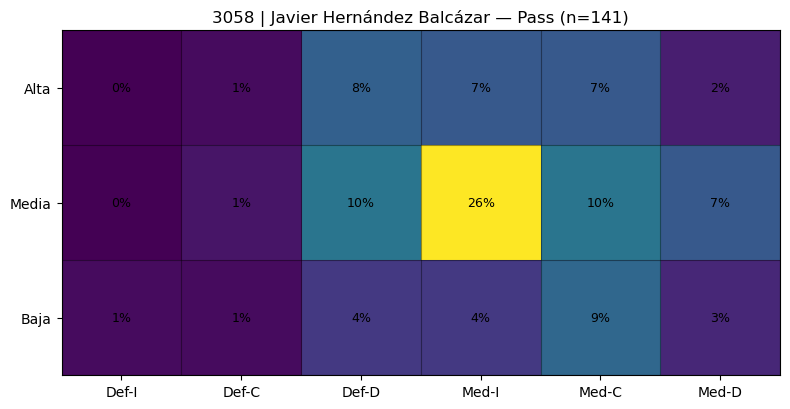

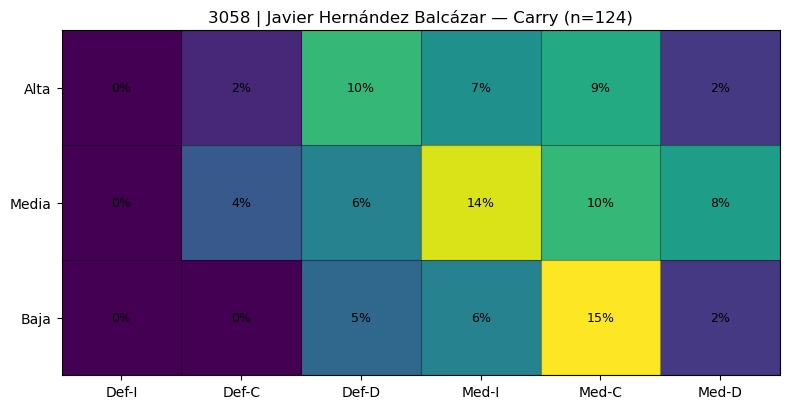

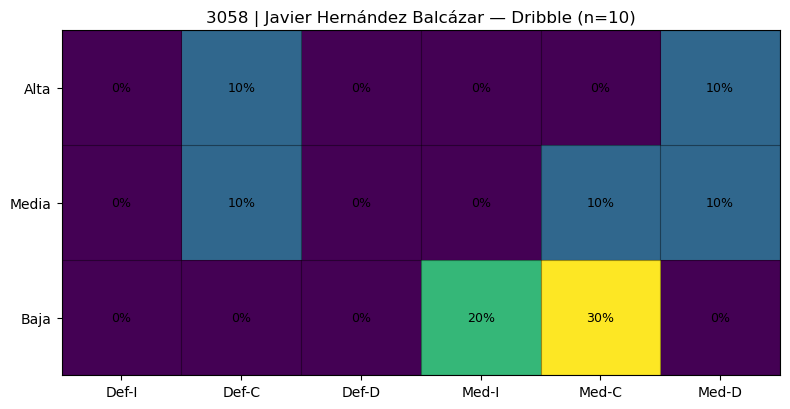

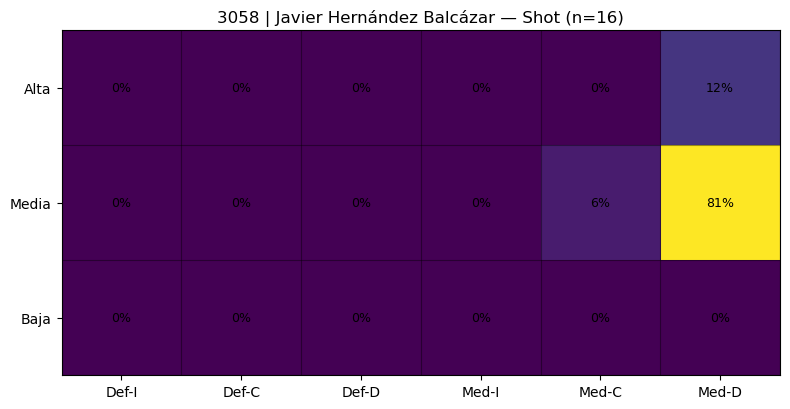

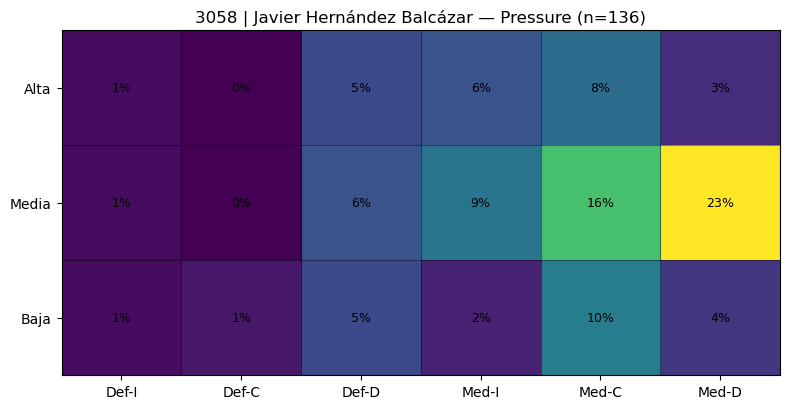

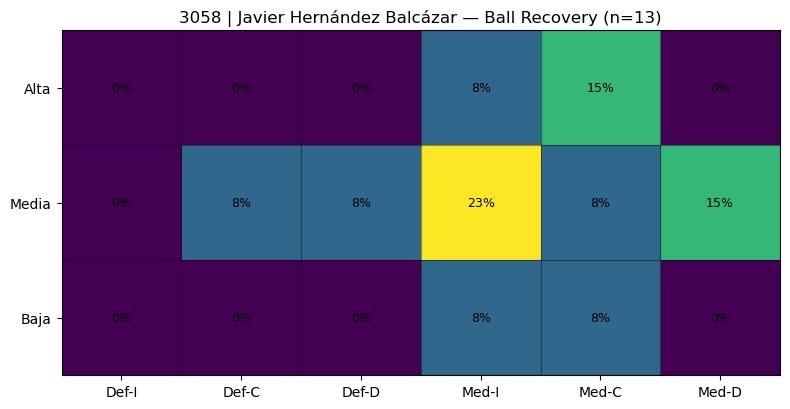

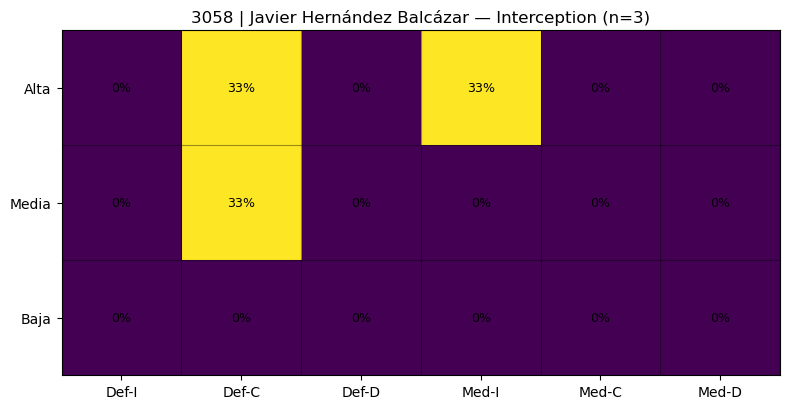

In [ ]:
# 6×3 bins en coordenadas StatsBomb (x:0–120, y:0–80)
_X_BINS = np.linspace(0, 120, 7)   # 6 columnas (ancho 20)
_Y_BINS = np.linspace(0, 80, 4)    # 3 filas (alto ~26.67)

# conjunto de tipos de eventos que se graficarán
BASE_TYPES = {'Pass','Carry','Dribble','Shot','Ball Recovery','Interception','Pressure'}

def zone_matrix_6x3(events_df, player_id, base_type='Pass', normalize='row'):
    """
    Devuelve una matriz 3x6 (rows=y de arriba a abajo: Izq/Cen/Der -> en y son 3 filas),
    cols=x (Def→Ata de izquierda a derecha), con los conteos de acciones del tipo base.
    normalize: None | 'all' -> porcentaje del total de ese tipo
               'row' -> cada fila suma 1
    """
    assert base_type in BASE_TYPES, f"base_type inválido: {base_type}" # valida que el tipo de eventos esté soportado
    df = events_df[(events_df.get('player_id')==player_id) & (events_df['type']==base_type)].copy() # filtra los eventos del jugador y del tipo base, copia para evitar advertencias de asignacion
    if df.empty:
        # si no hay eventos de ese tipo, devuelve una matriz 3x6 de ceros y n=0
        return np.zeros((3,6)), 0

    xs, ys = [], []
    for _, r in df.iterrows():
        # recorre filas y acumula listas separadas de x y saltando filas sin location
        x,y = _xy_from_row(r)
        if x is None or y is None: 
            continue
        xs.append(x); ys.append(y)
    if not xs:
        return np.zeros((3,6)), len(df) # si ninguna fila tenía coordenadas válidas, devuelve ceros y el número de filas filtradas

    H, _, _ = np.histogram2d(ys, xs, bins=[_Y_BINS, _X_BINS])  # shape (3,6), y primero
    # Por defecto, y=0 es [0,26.7] (banda izq) y y sube hacia abajo; volteamos para “arriba→abajo”
    H = H[::-1, :]  # ahora fila 0 ~ tercio superior (Izq), columna 0 ~ zona DEF izquierda

    if normalize == 'all':
        # normalización global: divide toda la matriz por el total de eventos de ese tipo
        s = H.sum()
        if s > 0: H = H / s
    elif normalize == 'row':
        # normalización por fila: cada fila se divide por su suma, evita división entre 0 reemplazando sumas nulas por 1.
        rs = H.sum(axis=1, keepdims=True)
        rs[rs==0] = 1.0
        H = H / rs

    return H, len(df) # devuelve la matriz 3x6 (conteo y proporciones) y n (número de eventos considerados)

def plot_zone_heatmap(H, title="", annotate=True):
    # dibuja un heatmap de la matriz H, crea figuras y ejes
    fig, ax = plt.subplots(figsize=(8, 4.2))
    im = ax.imshow(H, aspect='auto', origin='upper')
    # Líneas de la cuadrícula del campo (6x3)
    for c in range(7):
        ax.axvline(c-0.5, lw=0.8, alpha=0.4, color='k')
    for r in range(4):
        ax.axhline(r-0.5, lw=0.8, alpha=0.4, color='k')
    ax.set_xticks(range(6)); ax.set_yticks(range(3))
    ax.set_xticklabels(['Def-I','Def-C','Def-D','Med-I','Med-C','Med-D'], rotation=0)
    ax.set_yticklabels(['Alta','Media','Baja'])  # “Alta” ~ carril izquierdo del pitch SB (y pequeño)
    ax.set_title(title)
    if annotate:
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                val = H[i,j]
                txt = f"{val:.0f}" if val>=1 and val==int(val) else (f"{val*100:.0f}%" if val<=1.0 else f"{val:.0f}")
                ax.text(j, i, txt, ha='center', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()

# === Ejemplo de uso ===
# 1) Elige un jugador (usa tu dataframe players_index si quieres buscar por nombre)
# find_players("Fidalgo")
pid_demo = players_index.iloc[0]['player_id']  # cambia por el id que quieras

# 2) Genera y grafica para varios tipos base
for b in ['Pass','Carry','Dribble','Shot','Pressure','Ball Recovery','Interception']:
    H, n = zone_matrix_6x3(events, player_id=pid_demo, base_type=b, normalize='all')  # 'all' -> porcentajes del total de ese tipo
    title = f"{int(pid_demo)} | {players_index.loc[players_index.player_id==pid_demo,'player_name'].iloc[0]} — {b} (n={n})"
    plot_zone_heatmap(H, title=title, annotate=True)


In [ ]:
# Conjunto de tipos base de acciones válidas para comparar
BASE_TYPES = {'Pass','Carry','Dribble','Shot','Ball Recovery','Interception','Pressure'}

def _tercio(x):
    # clasifica la posición longitudinal x en el tercio del campo 
    if x is None: return None
    return 'Def' if x < 40 else ('Med' if x < 80 else 'Ata')

def _carril(y):
    # Clasifica la posición lateral y en carriles
    if y is None: return None
    return 'Izq' if y < 26.67 else ('Cen' if y < 53.33 else 'Der')

def _zone_label(x,y):
    # combina tercio y carril para formar una etiqueta de zona
    t, c = _tercio(x), _carril(y)
    return None if (t is None or c is None) else f"{t}-{c}"

def _player_zone_counts(df, pid, base_type):
    # filtra el DataFrame a las filas del jugador y del tipo de accion 
    sub = df[(df.get('player_id')==pid) & (df['type']==base_type)]
    zones = []
    # recorre las filas, extrae (x,y) calcula la zona y si existe la agrega a la lista
    for _, r in sub.iterrows():
        x,y = _xy_from_row(r)
        z = _zone_label(x,y)
        if z: zones.append(z)
    return pd.Series(zones).value_counts().rename_axis('zone').rename('count') # convierte la lista de zonas en una serie, cuenta ocurrencias por zona y devuelve una serie con indice zona y valores count

def compare_players_by_zone(df, pid_a, pid_b, base_type, top=None):
    # Función principal: compara distribución espacial de un tipo de acción entre dos jugadores.
    assert base_type in BASE_TYPES, f"base_type inválido: {base_type}" # valida que el tipo de acción sea permitido
    ca = _player_zone_counts(df, pid_a, base_type) # obtiene los conteos por zona para el jugador A
    cb = _player_zone_counts(df, pid_b, base_type) # obtiene los conteos por zona para el jugador B

    # unir todas las zonas posibles
    zones = sorted(set(ca.index).union(cb.index),
                   key=lambda z: ('Def','Med','Ata').index(z.split('-')[0]) * 3 +
                                 ('Izq','Cen','Der').index(z.split('-')[1]))
    # crea la lista ordenada de todas las zonas presentes en A o B
    out = pd.DataFrame(index=zones) # crea un DataFrame con índice en esas zonas
    out['A_count'] = ca.reindex(zones).fillna(0).astype(int) # añade columnas de conteo para A
    out['B_count'] = cb.reindex(zones).fillna(0).astype(int) # añade columnas de conteo para B
    out['A_pct']   = (out['A_count'] / max(out['A_count'].sum(), 1.0)).round(4) # calcula porcentajes por zona sobre el total de acciones del tipo en el jugador A
    out['B_pct']   = (out['B_count'] / max(out['B_count'].sum(), 1.0)).round(4) # calcula porcentajes por zona sobre el total de acciones del tipo en el jugador B
    out['Δpct(B−A)'] = (out['B_pct'] - out['A_pct']).round(4) # calcula el delta de porcentajes: B - A por zona

    # totales al final
    total_row = pd.DataFrame({
        'A_count':[out['A_count'].sum()],
        'B_count':[out['B_count'].sum()],
        'A_pct':[1.0 if out['A_count'].sum()>0 else 0.0],
        'B_pct':[1.0 if out['B_count'].sum()>0 else 0.0],
        'Δpct(B−A)':[out['B_pct'].sum()-out['A_pct'].sum()]
    }, index=['TOTAL']) # prepara una fila TOTAL con sumas y porcentajes totales , el delta total debe ser 0 si ambos porcentajes suman 1.0

    if top:
        # si top está dado: ordena por |deltapct| desc (zonas con mayor diferencia relativa) y toma las top
        core = out.reindex(out.index, copy=True)
        core = core.iloc[np.argsort(-core['Δpct(B−A)'].abs().values)]
        core = core.head(top)
        out = pd.concat([core, total_row]) # concatena la fila TOTAL al final
    else:
        out = pd.concat([out, total_row]) # si no, concatena la fila TOTAL a la tabla completa

    # formato porcentajes legible
    disp = out.copy() 
    for c in ['A_pct','B_pct','Δpct(B−A)']:
        disp[c] = (disp[c]*100).round(1).astype(str) + '%' # convierte porcentajes a % con 1 decimal
    disp = disp.reset_index().rename(columns={'index':'zone'}) # pasa el índice (zona) a columna zone
    return disp # devuelve el DataFrame formateado

# === Cómo usar ===
# 1) elige dos IDs (usa find_players(...) si necesitas)
pid_A = 409157.0   # Leonardo Sepúlveda (ejemplo que usaste)
pid_B = 436788.0   # Alessandro De Jesús Tagle Salas (vecino)

# 2) compara por tipo de acción (puedes iterar por varios tipos)
for bt in ['Pass','Carry','Pressure','Ball Recovery','Interception','Dribble','Shot']:
    print(f"\n== {bt} ==")
    display(compare_players_by_zone(events, pid_A, pid_B, base_type=bt, top=9))  # top=9 => muestra las 9 zonas con mayor delta + TOTAL



== Pass ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Ata-Izq,0,4,0.0%,26.7%,26.7%
1,Def-Izq,5,2,31.2%,13.3%,-17.9%
2,Def-Cen,1,0,6.2%,0.0%,-6.2%
3,Med-Der,1,0,6.2%,0.0%,-6.2%
4,Med-Izq,8,8,50.0%,53.3%,3.3%
5,Med-Cen,1,1,6.2%,6.7%,0.4%
6,TOTAL,16,15,100.0%,100.0%,0.0%



== Carry ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Med-Cen,0,2,0.0%,22.2%,22.2%
1,Ata-Izq,0,2,0.0%,22.2%,22.2%
2,Med-Izq,5,4,62.5%,44.4%,-18.1%
3,Def-Izq,2,1,25.0%,11.1%,-13.9%
4,Def-Cen,1,0,12.5%,0.0%,-12.5%
5,TOTAL,8,9,100.0%,100.0%,-0.0%



== Pressure ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Ata-Izq,0,1,0.0%,16.7%,16.7%
1,Med-Izq,6,2,46.2%,33.3%,-12.8%
2,Med-Cen,1,1,7.7%,16.7%,9.0%
3,Def-Cen,1,0,7.7%,0.0%,-7.7%
4,Def-Izq,5,2,38.5%,33.3%,-5.1%
5,TOTAL,13,6,100.0%,100.0%,0.0%



== Ball Recovery ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Def-Izq,0,1,0.0%,25.0%,25.0%
1,Med-Izq,1,3,100.0%,75.0%,-25.0%
2,TOTAL,1,4,100.0%,100.0%,0.0%



== Interception ==


C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\3786731957.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count')
C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\3786731957.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count')


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,TOTAL,0,0,0.0%,0.0%,0.0%


C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\3786731957.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count')



== Dribble ==


C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\3786731957.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count')


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,TOTAL,0,0,0.0%,0.0%,0.0%


C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\3786731957.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count')



== Shot ==


C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\3786731957.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count')


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,TOTAL,0,0,0.0%,0.0%,0.0%


In [ ]:
# Lista de tipos de eventos base que se analizará
BASE_TYPES = ['Pass','Carry','Dribble','Shot','Ball Recovery','Interception','Pressure']

def _xy_from_row(row):
    # helper que extrae (x,y) de las columnas location de una fila de eventos
    loc = row.get('location', None)
    if isinstance(loc, (list,tuple)) and len(loc)>=2:
        # si location no existe o no tiene 2 valores, devuelve (None, None)
        return float(loc[0]), float(loc[1])
    return None, None

def _player_zone_counts(df, pid, base_type):
    # función que filtra el DataFrame df a eventos del jugador pid y del tipo base_type
    sub = df[(df.get('player_id')==pid) & (df['type']==base_type)]
    zones = []
    for _, r in sub.iterrows():
        # Recorre esos eventos, calcula la zona de cada uno y acumula las zonas válidas
        x,y = _xy_from_row(r)
        z = _zone_label(x,y)
        if z: zones.append(z)
    return pd.Series(zones).value_counts().rename_axis('zone').rename('count') # convierte la lista de zonas en un conteo por zona

def compare_players_by_zone(df, pid_a, pid_b, base_type, top=None):
    # helper que compara distribuciones por zona entre dos jugadores para un tipo de evento
    ca = _player_zone_counts(df, pid_a, base_type) # obtiene conteos por zona para A
    cb = _player_zone_counts(df, pid_b, base_type) # obtiene conteos por zona para B

    # unión de todas las zonas presentes en A o B
    zones = sorted(set(ca.index).union(cb.index),
                   key=lambda z: ('Def','Med','Ata').index(z.split('-')[0]) * 3 +
                                 ('Izq','Cen','Der').index(z.split('-')[1]))
    out = pd.DataFrame(index=zones) # crea el DataFrame base con esas zonas como índice
    out['A_count'] = ca.reindex(zones).fillna(0).astype(int) # rellena conteos de A
    out['B_count'] = cb.reindex(zones).fillna(0).astype(int) # rellena conteos de B
    out['A_pct']   = (out['A_count'] / max(out['A_count'].sum(), 1.0)).round(4) # porcentajes por zona para A
    out['B_pct']   = (out['B_count'] / max(out['B_count'].sum(), 1.0)).round(4) # porcentajes por zona para B
    out['Δpct(B−A)'] = (out['B_pct'] - out['A_pct']).round(4) # diferencia de porcentajes por zona B - A

    total_row = pd.DataFrame({
        # Fila Total con sumas y porcentajes totales
        'A_count':[out['A_count'].sum()],
        'B_count':[out['B_count'].sum()],
        'A_pct':[1.0 if out['A_count'].sum()>0 else 0.0],
        'B_pct':[1.0 if out['B_count'].sum()>0 else 0.0],
        'Δpct(B−A)':[out['B_pct'].sum()-out['A_pct'].sum()]
    }, index=['TOTAL'])

    if top:
        # si top está definido selecciona las top zonas con mayor |deltapct| y añade total
        core = out.reindex(out.index, copy=True)
        core = core.iloc[np.argsort(-core['Δpct(B−A)'].abs().values)]
        core = core.head(top)
        out = pd.concat([core, total_row]) 
    else:
        # si no, devuelve todas las zonas más total
        out = pd.concat([out, total_row])

    disp = out.copy() 
    for c in ['A_pct','B_pct','Δpct(B−A)']:
        # formatea porcentajes en % legible, mueve el índice a columna zone y devuelve el DataFrame listo para mostrar
        disp[c] = (disp[c]*100).round(1).astype(str) + '%'
    disp = disp.reset_index().rename(columns={'index':'zone'})
    return disp

def _cos(a,b):
    # similitud coseno para vectores
    return float(np.dot(a, b) / (norm(a)*norm(b) + 1e-12))

# Mapa id->nombre (desde player_docs)
pid2name = {float(pid): pname for (pid, pname) in player_docs.index} # diccionario auxiliar

def generate_player_comparison_report(pid_a, pid_b, events, player_docs, sif_pool=None, d2v=None, top_zones=9):
    # función orquestadora que arma un reporte comparativo entre dos jugadores: similitud vectoriales, tablas por zonas y explicación SIF
    name_a = pid2name.get(float(pid_a), str(pid_a)) # resuelve nombre de A
    name_b = pid2name.get(float(pid_b), str(pid_b))  # resuelve nombre de B

    # --- 1) Similitudes ---
    sim_sif = None
    if sif_pool and pid_a in sif_pool and pid_b in sif_pool:
        # si existe sif_pool y ambos ids están, calcula coseno entre sus vectores SIF
        sim_sif = _cos(sif_pool[pid_a][1], sif_pool[pid_b][1])

    sim_d2v = None
    if d2v is not None and str(pid_a) in d2v.dv and str(pid_b) in d2v.dv:
        # si existe Doc2Vec y ambos documentos están, calcula coseno entre embeddings Doc2Vec
        sim_d2v = _cos(d2v.dv[str(pid_a)], d2v.dv[str(pid_b)])

    meta = pd.DataFrame({
        # tabla corta con las dos métricas de similitud
        'metric':['SIF_cosine','Doc2Vec_cosine'],
        'value':[sim_sif, sim_d2v]
    })

    # --- 2) Tablas por zona (3×3) para cada tipo ---
    zone_tables = {}
    for bt in BASE_TYPES:
        # para cada tipo base guarda la tabla comparativa por zonas
        zone_tables[bt] = compare_players_by_zone(events, pid_a, pid_b, base_type=bt, top=top_zones)

    # --- 3) Explicación (si existe la función explain_similarity de paso anterior) ---
    explanation = None
    try:
        # intenta generar una explicación semántica basada en tokens SIF
        explanation = explain_similarity(pid_a, pid_b, player_docs, top_shared=10, top_unique=5)
    except Exception:
        # no definida en el entorno; lo dejamos en None
        explanation = None

    report = {
        # estructura del reporte
        'players': {'A': {'id': pid_a, 'name': name_a}, 'B': {'id': pid_b, 'name': name_b}},
        'similarities': meta,
        'zones': zone_tables,
        'explanation': explanation
    }

    # --- presentación rápida ---
    print(f"Comparativo: A={name_a} ({pid_a})  vs  B={name_b} ({pid_b})") 
    display(meta) # despliegue de la tabla de similitudes

    for bt in BASE_TYPES:
        # muestra, para cada tipo, la tabla por zonas
        print(f"\n== {bt} ==")
        display(zone_tables[bt])

    if explanation:
        # si hay explicacion SIF, despliega tablas de tokens compartidos y distintivos de A y B
        print("\n>> Top tokens compartidos")
        display(explanation['top_shared'])
        print("\n>> Rasgos distintivos de A")
        display(explanation['top_unique_A'])
        print("\n>> Rasgos distintivos de B")
        display(explanation['top_unique_B'])

    return report # devuelve el diccionario

# === Ejemplo de uso (ajusta los ids) ===
# report = generate_player_comparison_report(
#     pid_a=409157.0,  # Leonardo Sepúlveda Morales
#     pid_b=436788.0,  # Alessandro De Jesús Tagle Salas
#     events=events,
#     player_docs=player_docs,
#     sif_pool=sif_pool,
#     d2v=d2v,
#     top_zones=9
# )


In [44]:
report = generate_player_comparison_report(
    pid_a=409157.0,  # Leonardo Sepúlveda Morales
    pid_b=436788.0,  # Alessandro De Jesús Tagle Salas
    events=events,
    player_docs=player_docs,
    sif_pool=sif_pool,
    d2v=d2v,
    top_zones=9
) # uso de la función

C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\806373201.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count') # convierte la lista de zonas en un conteo por zona
C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\806373201.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone').rename('count') # convierte la lista de zonas en un conteo por zona
C:\Users\alexa\AppData\Local\Temp\ipykernel_25296\806373201.py:40: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(zones).value_counts().rename_axis('zone

Comparativo: A=Leonardo Sepulveda Morales (409157.0)  vs  B=Alessandro De Jesús Tagle Salas (436788.0)


,metric,value
0,SIF_cosine,0.952016
1,Doc2Vec_cosine,0.964817



== Pass ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Ata-Izq,0,4,0.0%,26.7%,26.7%
1,Def-Izq,5,2,31.2%,13.3%,-17.9%
2,Def-Cen,1,0,6.2%,0.0%,-6.2%
3,Med-Der,1,0,6.2%,0.0%,-6.2%
4,Med-Izq,8,8,50.0%,53.3%,3.3%
5,Med-Cen,1,1,6.2%,6.7%,0.4%
6,TOTAL,16,15,100.0%,100.0%,0.0%



== Carry ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Med-Cen,0,2,0.0%,22.2%,22.2%
1,Ata-Izq,0,2,0.0%,22.2%,22.2%
2,Med-Izq,5,4,62.5%,44.4%,-18.1%
3,Def-Izq,2,1,25.0%,11.1%,-13.9%
4,Def-Cen,1,0,12.5%,0.0%,-12.5%
5,TOTAL,8,9,100.0%,100.0%,-0.0%



== Dribble ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,TOTAL,0,0,0.0%,0.0%,0.0%



== Shot ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,TOTAL,0,0,0.0%,0.0%,0.0%



== Ball Recovery ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Def-Izq,0,1,0.0%,25.0%,25.0%
1,Med-Izq,1,3,100.0%,75.0%,-25.0%
2,TOTAL,1,4,100.0%,100.0%,0.0%



== Interception ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,TOTAL,0,0,0.0%,0.0%,0.0%



== Pressure ==


,zone,A_count,B_count,A_pct,B_pct,Δpct(B−A)
0,Ata-Izq,0,1,0.0%,16.7%,16.7%
1,Med-Izq,6,2,46.2%,33.3%,-12.8%
2,Med-Cen,1,1,7.7%,16.7%,9.0%
3,Def-Cen,1,0,7.7%,0.0%,-7.7%
4,Def-Izq,5,2,38.5%,33.3%,-5.1%
5,TOTAL,13,6,100.0%,100.0%,0.0%



>> Top tokens compartidos


,token,zona,tipo,peso_total,peso_A,peso_B
0,Ball Recovery_Z_Med_Izq,Z_Med,Ball Recovery,0.713851,0.178463,0.535389



>> Rasgos distintivos de A


,token,zona,tipo,peso_A



>> Rasgos distintivos de B


,token,zona,tipo,peso_B
0,Ball Recovery_Z_Def_Izq,Z_Def,Ball Recovery,0.197585
1,Pass_Z_Def_Izq_BajoPresion,Z_Def,Pass,0.141143
2,Pressure_Z_Ata_Izq,Z_Ata,Pressure,0.124579
3,Carry_Z_Ata_Izq_BajoPresion,Z_Ata,Carry,0.064244
4,Carry_Z_Ata_Izq,Z_Ata,Carry,0.050837
